In [ ]:
!pip install -qqq catboost

In [ ]:
import os
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor

In [ ]:
gas = gas_test.iloc[:10000]

In [ ]:
id = 'NPLV'

In [ ]:
produv_ready_test = extract_produv(produv_or)

In [ ]:
produv_ready_train = extract_produv(produv_or_train)

In [ ]:
# gas_test = pd.read_csv('ready_gas_test.csv', index_col='NPLV')
# gas_train = pd.read_csv('ready_gas_train.csv', index_col='NPLV')
target = pd.read_csv('target_train.csv', index_col='NPLV').fillna(0)

In [ ]:
class Params:
  depth = 3
  iter = 2000
  lr = 0.1
  l2_reg = 3
params = Params()

In [ ]:
def prod_train(data_train, data_test, target):
  cat_tst = CatBoostRegressor(
    iterations=2000,
    depth=7,
    learning_rate=0.1,
    l2_leaf_reg=3,
    random_seed=42
  )
  cat_c = CatBoostRegressor(
    iterations=2000,
    depth=3,
    learning_rate=0.1,
    l2_leaf_reg=3,
    random_seed=42
  )

  cat_tst.fit(data_train, target['TST'], verbose=False)
  cat_c.fit(data_train, target['C'], verbose=False)

  preds_tst = cat_tst.predict(data_test)
  preds_c = cat_c.predict(data_test)
  preds = pd.DataFrame({'NPLV': data_test.index, 'C' : preds_c, 'TST' : preds_tst})

  return preds

In [ ]:
gas_test = pd.read_csv('ready_gas_test.csv', index_col='NPLV')
gas_train = pd.read_csv('ready_gas_train.csv', index_col='NPLV')

In [ ]:
produv_test = pd.read_csv('produv_test.csv', index_col='NPLV')
produv_train = pd.read_csv('produv_train.csv', index_col='NPLV')

In [ ]:
my_train = gas_train.join(produv_train)
my_test = gas_test.join(produv_test)

In [ ]:
sip_test = pd.read_csv('sip_test.csv', index_col='NPLV')
sip_train = pd.read_csv('sip_train.csv', index_col='NPLV')

In [ ]:
plavki_test = pd.read_csv('plavki_test.csv', index_col='NPLV')
plavki_train = pd.read_csv('plavki_train.csv', index_col='NPLV')

In [ ]:
train = my_train.join(sip_train).join(plavki_train)
test = my_test.join(sip_test).join(plavki_test)

In [ ]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [ ]:
top40 = pd.read_csv('features.csv').iloc[:30]['cols']
test_all = pd.read_csv('test_all.csv', index_col='NPLV')#[top40]
train_all = pd.read_csv('train_all.csv', index_col='NPLV')#[top40]
target = pd.read_csv('target_train.csv', index_col='NPLV').fillna(0)

In [ ]:
o_train = train_all.iloc[:, 58:]
o_test = test_all.iloc[:, 58:]

In [ ]:
train = my_train.join(o_train)
test = my_test.join(o_test)

In [ ]:
tt = train.append(test)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(tt)
train[:] = scaler.transform(train)
test[:] = scaler.transform(test)

In [ ]:
all = train.join(target)

In [ ]:
preds = prod_train(train, test, target)

In [ ]:
preds.to_csv(f'submission_{int(time())}.csv', index=False)

In [ ]:
cat_c = CatBoostRegressor(iterations=150, task_type='GPU', random_seed=42)
cat_tst = CatBoostRegressor(iterations=150, task_type='GPU', random_seed=42)

In [ ]:
param_grid = {
    'depth' : [3, 5, 7, 9, 11],
    'learning_rate' : [0.03, 0.05, 0.1],
    'l2_leaf_reg' : [3, 5, 7]
}

best_cat_c = GridSearchCV(cat_c, param_grid=param_grid, n_jobs=-1, cv=2, verbose=1).fit(train[top20c], target['C']).best_estimator_
best_cat_tst = GridSearchCV(cat_tst, param_grid=param_grid, n_jobs=-1, cv=2, verbose=1).fit(train[top20tst], target['TST']).best_estimator_

In [ ]:
preds_tst = best_cat_tst.predict(test[top20tst])
preds_c = best_cat_c.predict(test[top20c])
preds = pd.DataFrame({'NPLV': test.index, 'C' : preds_c, 'TST' : preds_tst})

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_c = lgb.LGBMRegressor(n_estimators=250)
lgb_tst = lgb.LGBMRegressor(n_estimators=250)

In [ ]:
param_grid = {
    'max_depth ' : [3, 7, 9, -1],
    'learning_rate' : [0.03, 0.05, 0.1],
    'reg_lambda' : [3, 5, 0]
}

best_lgb_c = GridSearchCV(lgb_c, param_grid=param_grid, n_jobs=-1, cv=2, verbose=1).fit(train, target['C']).best_estimator_
best_lgb_tst = GridSearchCV(lgb_tst, param_grid=param_grid, n_jobs=-1, cv=2, verbose=1).fit(train, target['TST']).best_estimator_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.4min finished


Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.3min finished


In [ ]:
preds_tst = best_lgb_tst.predict(test)
preds_c = best_lgb_c.predict(test)
preds = pd.DataFrame({'NPLV': test.index, 'C' : preds_c, 'TST' : preds_tst})

In [ ]:
preds.to_csv(f'submission_{int(time())}.csv', index=False)

# Research

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
np.array(target['C'])

array([0.06 , 0.097, 0.091, ..., 0.141, 0.27 , 0.183])

In [ ]:
forest1 = RandomForestRegressor(random_state=42)
forest1.fit(train, target['C'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
forest2 = RandomForestRegressor(random_state=42)
forest2.fit(train, target['TST'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
importance2 = pd.DataFrame({'cols': list(train.columns), 'importance': forest2.feature_importances_})

In [ ]:
sorted_imp.to_csv('features.csv')

In [ ]:
importance2['importance'] *= 1000

In [ ]:
sorted_imp2 = importance2.sort_values(['importance'], ascending=False)

In [ ]:
sorted_imp2

,cols,importance
146,O2_sum,157.740038
53,dur_10_H2_mean,104.055281
14,dur_10_H2_sum,73.027886
42,dur_5_H2_mean,34.343619
138,plavka_NMZ,29.683109
...,...,...
179,VDL_48,0.072819
172,NML_СК,0.020821
166,NML_К,0.002044
174,VDL_4,0.000018


In [ ]:
top20c = sorted_imp.iloc[:20]['cols']

In [ ]:
top40tst

146                     O2_sum
53              dur_10_H2_mean
14               dur_10_H2_sum
42               dur_5_H2_mean
138                 plavka_NMZ
78              dur_all_H2_sum
13                dur_5_H2_sum
79             dur_all_H2_mean
152          Продувка_duration
136                изв_ЦОИ_sum
154                          T
110           O2_pressure_diff
164                      VES_y
143       plavka_NAPR_ZAD_МНЛЗ
149      Завалка лома_duration
97                       T_max
96                     tf2_max
151    Заливка чугуна_duration
61              dur_30_AR_mean
150       Нагрев лома_duration
140             plavka_ST_FURM
31               dur_1_H2_mean
124                   pol_diff
156                         MN
90               dur_all_T_sum
74              dur_all_CO_sum
157                          S
130                 ФЛЮМАГ_sum
3                dur_30_AR_sum
126                    pol_end
111                   tf1_diff
125                  time_diff
147     

In [ ]:
gases = ['AR', 'CO', 'CO2', 'H2', 'N2', 'O2']
commons = ['O2_pressure', 'tf1', 'tf2', 'T']
vcol = ['V']
timecol = ['Time']
allcols = gases + commons + vcol

In [ ]:
df = deepcopy(all)

In [ ]:
dropcols = [f'dur_{i}_{col}_sum' for i in [5, 10] for col in gases + vcol] + \
           [f'dur_{i}_{col}_mean' for i in [1, 5, 10, 30, 'all'] for col in gases] + \
           [f'dur_{i}_{col}_mean' for i in [5, 10] for col in commons+vcol] + \
           [f'dur_{i}_tf2_{t}' for i in [1, 5, 10, 30, 'all'] for t in ['mean']] + \
           [f'dur_{i}_sum' for i in [5, 10]] + [f'dur_{i}_mean' for i in [1, 5, 10, 30, 'all']] + \
           ['tf2_last', 'tf2_max', 'dur_all_tf2_sum'] + [f'{col}_last' for col in ['H2', 'CO', 'O2']]

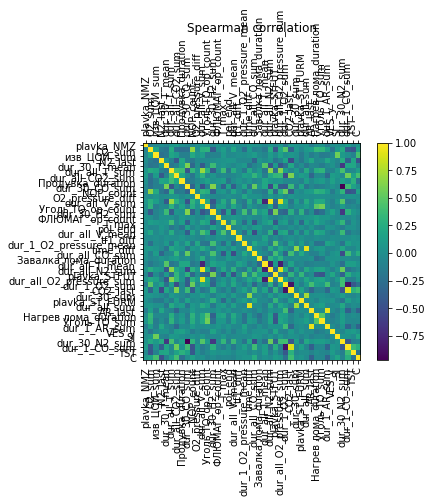

In [ ]:
n = df.shape[1]
names = list(df.columns)

fig = plt.figure()
ax = plt.gca()

im = ax.matshow(df.corr('spearman'), interpolation='none')
fig.colorbar(im)

ax.set_xticks(np.arange(n))
ax.set_xticklabels(names)
ax.set_yticks(np.arange(n))
ax.set_yticklabels(names)

# Set ticks on both sides of axes on
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=90,
         ha="right", va="center", rotation_mode="anchor")
# Rotate and align top ticklabels
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=90,
         ha="left", va="center",rotation_mode="anchor")

ax.set_title("Spearman correlation", pad=100)
# fig.tight_layout()
plt.show()

In [ ]:
cat_tst = CatBoostRegressor(iterations=2000)
cat_c = CatBoostRegressor(iterations=2000)

In [ ]:
target = pd.read_csv('../data/raw/target_train.csv', index_col='NPLV').fillna(0)

In [ ]:
X_train_tst, X_test_tst, y_train_tst, y_test_tst = train_test_split(produv_ready_train, target['TST'], test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(produv_ready_train, target['C'], test_size=0.2, random_state=42)

In [ ]:
cat_tst.fit(X_train_tst, y_train_tst, verbose=False)
cat_c.fit(X_train_c, y_train_c, verbose=False)

In [ ]:
preds_tst = cat_tst.predict(X_test_tst)
preds_c = cat_c.predict(X_test_c)

In [ ]:
def metric(answers, user_csv):

    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(answers['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

In [ ]:
preds = pd.DataFrame({'C' : preds_c, 'TST' : preds_tst})
groun_truth = pd.DataFrame({'C' : y_test_c, 'TST' : y_test_tst})
metric(groun_truth, preds)

In [ ]:
cat_tst.fit(produv_ready_train, target['TST'], verbose=False)
cat_c.fit(produv_ready_train, target['C'], verbose=False)

In [ ]:
preds_tst = cat_tst.predict(produv_ready_test)
preds_c = cat_c.predict(produv_ready_test)
preds = pd.DataFrame({'NPLV': produv_ready_test.index, 'C' : preds_c, 'TST' : preds_tst})

In [ ]:
preds.to_csv(f'../data/submission_{int(time())}.csv', index=False)